<a href="https://colab.research.google.com/github/Jughead19/Virality_Prediction/blob/master/simpleViralityPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install praw

In [0]:
import praw
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics 
from sklearn import preprocessing


In [0]:
"""
First step is to create an application through reddit, you need a reddit account for this. Include a script name and description and then put this in the uri box 
http://localhost:8080  

Once this is done succesfully you can find two strings one on the top right corner with length 14character and the other is a "secret" of length 27character"""

In [0]:
reddit = praw.Reddit(client_id='enter the 14character string here', client_secret='secret key here',user_agent='name you gave in the application',username='reddit username',password='reddit password')

In [0]:
subreddit=reddit.subreddit('eagles+nba+sports+FIFA')

In [0]:
top_reddit=subreddit.top(time_filter='year',limit=3500)

In [0]:
data={'title':[],'id':[],'subreddit':[],'comments':[],'creationdate':[],'ups':[],'trophies':[],'is_self':[],'is_video':[],'subscribers':[],'score':[]}

In [0]:
for submission in top_reddit:
  data['title'].append(submission.title)
  data['id'].append(submission.id)
  data['subreddit'].append(submission.subreddit)
  data['comments'].append(submission.num_comments)
  data['creationdate'].append(submission.created)
  data['ups'].append(submission.ups)
  data['trophies'].append(submission.total_awards_received)
  data['is_self'].append(submission.is_self)
  data['is_video'].append(submission.is_video)
  data['subscribers'].append(submission.subreddit_subscribers)
  data['score'].append(submission.score)

In [0]:
df=pd.DataFrame(data)
df.head()


,title,id,subreddit,comments,creationdate,ups,trophies,is_self,is_video,subscribers,score
0,[Surette] TMZ is reporting Kobe Bryant has die...,eubekc,nba,12398,1.580096e+09,105540,0,False,False,3227805,105540
1,[Charania] The NBA has suspended its season.,fh8e8c,nba,12251,1.584006e+09,98391,0,False,False,3227805,98391
2,"Max Kellerman on Lebron: ""It's called selling ...",dic2ak,nba,4174,1.571193e+09,94425,0,False,False,3227805,94425
3,Fallon Sherrock just became the first woman to...,ec3d3l,sports,3435,1.576651e+09,90024,0,False,False,17020385,90024
4,I analyzed James Harden's performance in every...,dt0ucg,nba,4284,1.573176e+09,89050,0,True,False,3227805,89050


In [0]:
#to convert creation date into the format year month day hr min sec

def get_date(creationdate):
  return dt.datetime.fromtimestamp(creationdate)
_timestamp= df["creationdate"].apply(get_date)
df=df.assign(timestamp=_timestamp)
#extracting the hour and dayof the week from the timestamp created 
df['hour_of_day']=df['timestamp'].dt.hour
df['weekday']=df['timestamp'].dt.dayofweek

In [0]:
#converting into a string so as to change the datatype from a subreddit object
df['subreddit']=df['subreddit'].astype(str)
df.head()

,title,id,subreddit,comments,creationdate,ups,trophies,is_self,is_video,subscribers,score,timestamp,hour_of_day,weekday
0,[Surette] TMZ is reporting Kobe Bryant has die...,eubekc,nba,12398,1.580096e+09,105540,0,False,False,3227805,105540,2020-01-27 03:29:00,3,0
1,[Charania] The NBA has suspended its season.,fh8e8c,nba,12251,1.584006e+09,98391,0,False,False,3227805,98391,2020-03-12 09:32:16,9,3
2,"Max Kellerman on Lebron: ""It's called selling ...",dic2ak,nba,4174,1.571193e+09,94425,0,False,False,3227805,94425,2019-10-16 02:25:14,2,2
3,Fallon Sherrock just became the first woman to...,ec3d3l,sports,3435,1.576651e+09,90024,0,False,False,17020385,90024,2019-12-18 06:43:31,6,2
4,I analyzed James Harden's performance in every...,dt0ucg,nba,4284,1.573176e+09,89050,0,True,False,3227805,89050,2019-11-08 01:19:44,1,4


In [0]:
#takes in data frame and a series of column to return dataframe with the categorical columns one hot encoded
def categorical_func(column_name,df):
  df[column_name ]=pd.Categorical(df[column_name])
  dummy_df=pd.get_dummies(df[column_name],prefix=column_name)
  df=pd.concat([df,dummy_df],axis=1)
  return df

In [0]:
cat_arr=['subreddit','is_self','is_video']
for col in cat_arr:
  df=categorical_func(col,df)

In [0]:
df.shape

(3500, 22)

In [0]:
df.describe()

,comments,creationdate,ups,trophies,subscribers,score,hour_of_day,weekday,subreddit_FIFA,subreddit_eagles,subreddit_nba,subreddit_sports,is_self_False,is_self_True,is_video_False,is_video_True
count,3500.000000,3.500000e+03,3500.000000,3500.000000,3.500000e+03,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,539.977143,1.572971e+09,8265.964286,1.320000,4.423661e+06,8265.964286,10.796857,2.836571,0.284571,0.233714,0.284857,0.196857,0.854571,0.145429,0.888571,0.111429
std,944.632390,8.870058e+06,11049.144244,7.209628,6.363059e+06,11049.144244,7.572014,2.042876,0.451275,0.423253,0.451411,0.397680,0.352583,0.352583,0.314707,0.314707
min,8.000000,1.556549e+09,458.000000,0.000000,1.982330e+05,458.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,84.750000,1.565343e+09,1138.000000,0.000000,3.769970e+05,1138.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,202.000000,1.573603e+09,2783.500000,0.000000,3.769970e+05,2783.500000,10.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,671.000000,1.580311e+09,12192.000000,1.000000,3.227806e+06,12192.000000,19.000000,5.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,16875.000000,1.587893e+09,105540.000000,313.000000,1.702039e+07,105540.000000,23.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#For a post to go viral we are considering standard deviation of score as a threshold.

df['virality']=[1 if x>df.score.std() else 0 for x in df.score]

In [0]:
df.head()

,title,id,subreddit,comments,creationdate,ups,trophies,is_self,is_video,subscribers,score,timestamp,hour_of_day,weekday,subreddit_FIFA,subreddit_eagles,subreddit_nba,subreddit_sports,is_self_False,is_self_True,is_video_False,is_video_True,virality
0,[Surette] TMZ is reporting Kobe Bryant has die...,eubekc,nba,12398,1.580096e+09,105540,0,False,False,3227805,105540,2020-01-27 03:29:00,3,0,0,0,1,0,1,0,1,0,1
1,[Charania] The NBA has suspended its season.,fh8e8c,nba,12251,1.584006e+09,98391,0,False,False,3227805,98391,2020-03-12 09:32:16,9,3,0,0,1,0,1,0,1,0,1
2,"Max Kellerman on Lebron: ""It's called selling ...",dic2ak,nba,4174,1.571193e+09,94425,0,False,False,3227805,94425,2019-10-16 02:25:14,2,2,0,0,1,0,1,0,1,0,1
3,Fallon Sherrock just became the first woman to...,ec3d3l,sports,3435,1.576651e+09,90024,0,False,False,17020385,90024,2019-12-18 06:43:31,6,2,0,0,0,1,1,0,1,0,1
4,I analyzed James Harden's performance in every...,dt0ucg,nba,4284,1.573176e+09,89050,0,True,False,3227805,89050,2019-11-08 01:19:44,1,4,0,0,1,0,0,1,1,0,1


In [0]:
#writing this data frame to csv file
df.to_csv("scrapeddata.csv")

In [0]:
#scaling the comments column so as to converge the gradient descent befor iteration limit is reached 

min_max_scaler = preprocessing.MinMaxScaler()
df['comments'] = min_max_scaler.fit_transform(df['comments'].values.reshape(-1,1))

In [0]:
x=df[['comments','trophies','subreddit_FIFA','subreddit_eagles','subreddit_nba', 'subreddit_sports', 'is_self_False', 'is_self_True',
       'is_video_False', 'is_video_True']]
y=df['virality'].values.flatten()

In [0]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)

In [0]:
logreg = LogisticRegression()
logreg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred=logreg.predict(x_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[416,  80],
       [ 33, 171]])

In [0]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8385714285714285
Precision: 0.6812749003984063
Recall: 0.8382352941176471


In [0]:
creation_age=df.loc[x_test.index]

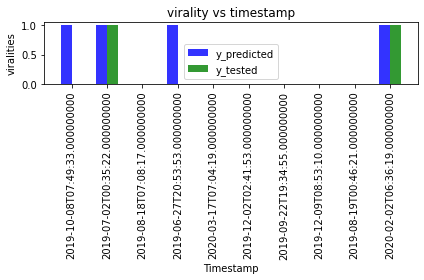

In [0]:
index_x=creation_age['timestamp'].values[:10]
index_y1=y_pred[:10]
index_y2=y_test[:10]
fig, ax = plt.subplots()
bar_width = 0.3
opacity = 0.8
index=np.arange(10)
rects1 = plt.bar(index, index_y1, bar_width,
alpha=opacity,
color='b',
label='y_predicted')

rects2 = plt.bar(index+ bar_width, index_y2, bar_width,
alpha=opacity,
color='g',
label='y_tested')

plt.xlabel('Timestamp')
plt.ylabel('viralities')
plt.title('virality vs timestamp')
plt.xticks(index + bar_width/2, (i for i in index_x),rotation='vertical')
plt.legend()

plt.tight_layout()
plt.show()